In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def reduce_mem_usage(df):
    """
    Iterate through all the columns of a dataframe and modify the data type

    Parameters
    ----------
    df : pandas.DataFrame

    Returns
    -------
    pandas.DataFrame

    """

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
# Read original data
nci60Act = pd.read_csv("../data/nci60Act_ccle.csv", index_col=0)
cell2ind = list(pd.read_table("../DrugCell/data/cell2ind.txt", header=None)[1])
nci60Act = nci60Act[list(set(cell2ind) & set(nci60Act.columns))]

In [4]:
# Create dataset for DrugCell
base = pd.DataFrame()
for i in nci60Act.columns:
    tmp = nci60Act[i].reset_index().dropna()
    tmp.columns = ['NSC', 'drug_response']
    tmp['CELL_LINE'] = [i]*len(tmp)
    base = pd.concat([base, tmp])
base = base.reset_index(drop=True)

In [5]:
# Add class label and SMILES
class_nsc = pd.read_csv('../DrugCell/data_rcellminer/class_by_nsc.csv')
base_class = base.merge(class_nsc, on='NSC', how='outer')
smiles = pd.read_csv('../data/nsc_cid_smiles.csv')[['NSC', 'SMILES']]
base_smiles = base_class.merge(smiles, on='NSC')

In [6]:
# Add NaN instead of Other label
t = pd.read_csv('../data/rcellminer.csv')[['NSC', 'MOA']]
w = t.merge(class_nsc, on='NSC', how='outer')
w['class'] = [w['MECHANISM'][i] if w['MECHANISM'][i] != 'Other' else w['MOA'][i] for i in w.index]
w = w[['NSC', 'class']]
base_nan = base_smiles.merge(w, on='NSC')

In [7]:
# Choose top 5 classes
df = pd.DataFrame()
for i in ['Kinase', 'DNA', 'TUBB', 'HDAC', 'Apotosis']:
    df = pd.concat([
        base_nan[base_nan['class'] == i],
        df
    ])
    
df = pd.concat([
    df,
    base_nan[base_nan['class'].isna()]
])

In [8]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 62.83 MB
Memory usage after optimization is: 22.00 MB
Decreased by 65.0%


In [9]:
# Get morgan fingerprinting
t = []
for i in set(df['SMILES']):
    try:
        t.append([
            i,
            AllChem.GetMorganFingerprintAsBitVect(
                Chem.MolFromSmiles(i), 
                useChirality=True, 
                radius=2, 
                nBits=2048
            )
        ])
    except:
        pass

[19:08:01] Explicit valence for atom # 4 Sn, 5, is greater than permitted
[19:08:02] WARNING: not removing hydrogen atom without neighbors


In [10]:
t = np.array(t)
mfp = pd.DataFrame([np.array(i) for i in t[:, 1]])
mfp['SMILES'] = t[:, 0]
mfp = reduce_mem_usage(mfp)

/tmp/ipykernel_2776545/1148950312.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t = np.array(t)


Memory usage of dataframe is 353.95 MB
Memory usage after optimization is: 44.94 MB
Decreased by 87.3%


In [11]:
# Get cell to genes table
cell_line = pd.read_csv("../DrugCell/data_rcellminer/cell2mut.txt", header=None)
cell_line["CELL_LINE"] = pd.read_csv("../DrugCell/data_rcellminer/cell2ind.txt", sep="\t", header=None)[1]
cell_line = reduce_mem_usage(cell_line)

Memory usage of dataframe is 1.15 MB
Memory usage after optimization is: 0.15 MB
Decreased by 87.3%


In [12]:
df = df.merge(mfp, on="SMILES")
df = df.merge(cell_line, on="CELL_LINE")

In [13]:
df = df.drop(['NSC', 'MECHANISM', 'CELL_LINE', 'SMILES', 'drug_response'], axis=1)

In [14]:
t = df[df['class'].isna()].sample(n=df[~df['class'].isna()].shape[0], random_state=42)
df = pd.concat([df[~df['class'].isna()], t]).reset_index(drop=True)
translater = {j: i for i, j in enumerate(set(df['class']))}

/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:137: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:153: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "
/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


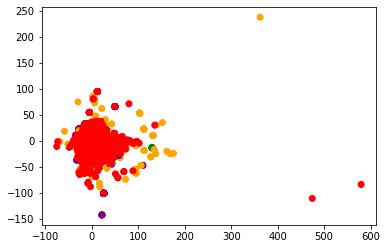

In [18]:
# Get and visualize TSNE
X_pca = TSNE(n_components=2, random_state=42).fit_transform(df.drop('class', axis=1))
colors = ['red','green','blue','purple', 'orange']
plt.scatter(
    X_pca[:,0], X_pca[:,1], 
    c=[translater[i] for i in df['class']], 
    cmap=matplotlib.colors.ListedColormap(colors)
)

### Use KNN for Unlabeled data

In [19]:
X = df.loc[~df['class'].isna()].drop('class', axis=1)
y = df.loc[~df['class'].isna()]['class']

In [20]:
knn = KNeighborsClassifier()
knn.fit(X, y)

/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


KNeighborsClassifier()

In [20]:
knn.score(X, y)

/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.8168039465166633

In [21]:
predicted_label = knn.predict(t.drop('class', axis=1))
t['class'] = predicted_label

/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### Get TSNE and visualize with new label

In [23]:
df = pd.concat([
    df[~df['class'].isna()],
    t
]).reset_index(drop=True)

/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:137: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/daal4py/sklearn/manifold/_t_sne.py:153: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "
/export/scratch/inoue019/envs/gpu1/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


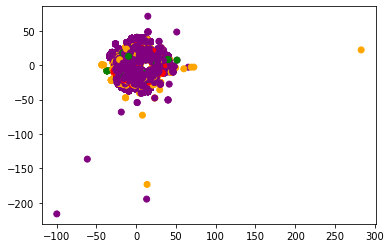

In [24]:
X_pca = TSNE(n_components=2, random_state=42).fit_transform(df.drop('class', axis=1))
colors = ['red','green','blue','purple', 'orange']
plt.scatter(
    X_pca[:,0], X_pca[:,1], 
    c=[translater[i] for i in df['class']], 
    cmap=matplotlib.colors.ListedColormap(colors)
)

In [28]:
df[df['class'] == 'DNA']

,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,...,2719,2720,2721,2722,2723,2724,2725,2726,2727,2728
83,DNA,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89592,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89593,DNA,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
89594,DNA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89595,DNA,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
